# Task 1: Fine-tune Chemical Language Model

The goal is to fine-tune a pre-trained chemical language model on a regression task using the Lipophilicity dataset. The task involves predicting the lipophilicity value for a given molecule representation (SMILES string). You will learn how to load and tokenize a dataset from HuggingFace, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [1]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling

import optuna
from optuna.trial import TrialState
from optuna.samplers import TPESampler

import matplotlib.pyplot as plt

import copy
import random
import pandas as pd
from tqdm import tqdm

# 1.Fine-tune a Chemical Language Model on Lipophilicity


## --- Step 1: Load Dataset ---

The dataset we are going to use is the [Lipophilicity](https://huggingface.co/datasets/scikit-fingerprints/MoleculeNet_Lipophilicity) dataset, part of [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Lipophilicity, also known as hydrophobicity, is a measure of how readily a substance dissolves in nonpolar solvents (such as oil) compared to polar solvents (such as water).

In [36]:
# Global Parameters
BATCH_SIZE = 16
EPOCHS = 40
EPOCHS_BO = 20

N_TRAIN_EXAMPLES = BATCH_SIZE * 30
N_VALID_EXAMPLES = BATCH_SIZE * 10

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

In [4]:
# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

The column names are 'SMILES', 'label'

3 Sample rows of train dataset
The sample data for index 70 is {'SMILES': 'CNC(=O)c1ccc(CC(=O)N(C)C2CCN(Cc3ccc(cc3)C(F)(F)F)CC2)cc1', 'label': 2.8}
The sample data for index 40 is {'SMILES': 'OB1N(C(=O)Nc2ccccc12)c3ccccc3', 'label': 1.4}
The sample data for index 41 is {'SMILES': 'CC(C)N(CCC(C(=O)N)(c1ccccc1)c2ccccn2)C(C)C', 'label': -0.54}

Distribution of label values for the train dataset


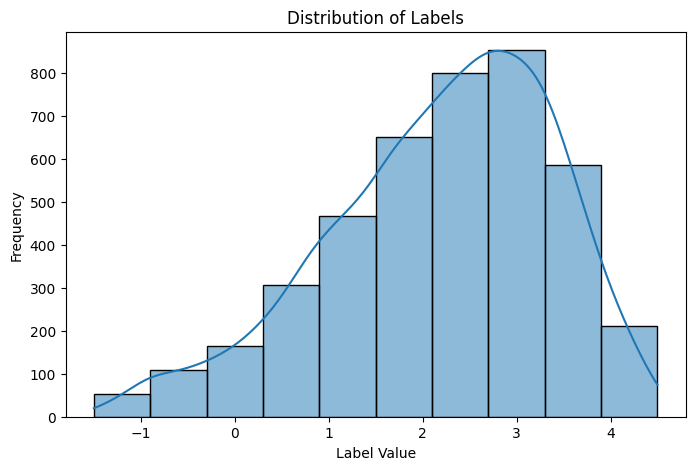

In [5]:
# Explore the dataset
# For example, print the column names and display a few sample rows
keys = list(dataset['train'][0].keys())
print(f"The column names are {', '.join(f"'{key}'" for key in keys)}")
print()

import random

random_indeces = [random.randint(1, 100) for _ in range(3)]
print("3 Sample rows of train dataset")
for index in random_indeces:
    print(f"The sample data for index {index} is {dataset['train'][index]}")
print()

print("Distribution of label values for the train dataset")
import matplotlib.pyplot as plt
import seaborn as sns

labels = [row['label'] for row in dataset['train']]

plt.figure(figsize=(8, 5))
sns.histplot(labels, bins=10, kde=True)  
plt.xlabel("Label Value")
plt.ylabel("Frequency")
plt.title("Distribution of Labels")

plt.show()

The distribution depicted above shows a negative skew that is present in the data.

In [6]:
# define a PyTorch Dataset class for handling SMILES strings and targets

class SMILESDataset(Dataset):
    def __init__(self, dataset, transform = None, target_transform = None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform 

    def __len__(self):
        return len(self.dataset['train'])
    
    def __getitem__(self, index):

        smiles = self.dataset['train'][index]['SMILES']
        label = self.dataset['train'][index]['label'] 

        if self.transform:
            smiles = self.transform(smiles)

        if self.target_transform:
            label = self.target_transform(label)

        return smiles, label

## --- Step 2: Split Dataset ---

As there is only one split (train split) in the original dataset, we need to split the data into training and testing sets by ourselves.

In [7]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

In [8]:
# split the data into training and test datasets
smiles_dataset = SMILESDataset(dataset)

train_size = int(0.8 * len(smiles_dataset))
test_size = len(smiles_dataset) - train_size

train_smiles, test_smiles = random_split(smiles_dataset, [train_size, test_size])

In [9]:
# construct Pytorch data loaders for both train and test datasets
train_dataloader = DataLoader(train_smiles, batch_size= BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_smiles, batch_size = BATCH_SIZE, shuffle = True)

## --- Step 3: Load Model ---

In [10]:
# load pre-trained model from HuggingFace
raw_language_model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)
raw_language_model.to(device)

MolformerModel(
  (embeddings): MolformerEmbeddings(
    (word_embeddings): Embedding(2362, 768, padding_idx=2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): MolformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x MolformerLayer(
        (attention): MolformerAttention(
          (self): MolformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (rotary_embeddings): MolformerRotaryEmbedding()
            (feature_map): MolformerFeatureMap(
              (kernel): ReLU()
            )
          )
          (output): MolformerSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (in

In [11]:
# Hyper parameter optimization using bayesian optimization
def define_model(trial):

    # Choice of Number of Layers
    n_layers = trial.suggest_int("n_layers", 1, 8)
    layers = []

    activations = {
        "ReLU" : nn.ReLU(),
        "LeakyReLU" : nn.LeakyReLU(),
        "ELU": nn.ELU(),
        "SELU": nn.SELU(),
        "GELU": nn.GELU()
    }

    in_features = 768
    for i in range(n_layers):
        # Choice of Number of unites per layer
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 1024)
        layers.append(nn.Linear(in_features, out_features))

        # Choice of type of activation function
        activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU","ELU","SELU", "GELU"])
        activation = activations[activation_name]
        layers.append(activation)

        layers.append(nn.BatchNorm1d(out_features))

        # Choice of dropout rate
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features

    layers.append(nn.Linear(in_features, 1))

    return nn.Sequential(*layers)

In [62]:
def objective(trial):
    
    model_bo = define_model(trial).to(device).float()

    # Choice of Learning rate value
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

    optimizer = torch.optim.Adam(model_bo.parameters(), lr=lr)

    for epoch in range(EPOCHS_BO):
        model_bo.train()
        for batch_idx, (smiles, label) in enumerate(train_dataloader):
            if batch_idx * BATCH_SIZE >= N_TRAIN_EXAMPLES:
                break

            label = label.to(device).float()
            
            smiles_token = tokenizer(smiles, padding=True, truncation=True, return_tensors="pt")
            smiles_token = {k: v.to(device) for k, v in smiles_token.items()}  
            smiles_output = raw_language_model(**smiles_token)
            smiles_embedding = smiles_output.last_hidden_state[:, 0, :].detach().float()

            optimizer.zero_grad()
            output = model_bo(smiles_embedding).squeeze()
            
            loss = F.mse_loss(output, label)
            loss.backward()
            optimizer.step()

        model_bo.eval()
        with torch.no_grad():
            for batch_idx, (smiles, label) in enumerate(test_dataloader):
                if batch_idx * BATCH_SIZE >= N_VALID_EXAMPLES:
                    break

                label = label.to(device).float()

                smiles_token = tokenizer(smiles, padding=True, truncation=True, return_tensors="pt")
                smiles_token = {k: v.to(device) for k, v in smiles_token.items()}  
                smiles_output = raw_language_model(**smiles_token)
                smiles_embedding = smiles_output.last_hidden_state[:, 0, :].detach().float()

                output = model_bo(smiles_embedding).squeeze()
                loss = F.mse_loss(output, label)

        trial.report(loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return loss  

In this part of code, we have created a Bayesian Hyperparameter optimization scheme for tuning the hyperparameters of the regression head. To achieve this goal we have used TPE sampler from optuna library for 600 trials. The summary statistics of trials are available below and description of the sampler used will be presented in the report of the project.

In [63]:
study = optuna.create_study(direction="minimize", sampler = TPESampler())
study.optimize(objective, n_trials = 200)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])


print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-02-17 18:10:04,558] A new study created in memory with name: no-name-79ac782b-9737-49ae-8df8-30573258d8c2
[I 2025-02-17 18:18:28,136] Trial 0 finished with value: 0.8526653051376343 and parameters: {'n_layers': 4, 'n_units_l0': 699, 'activation': 'ReLU', 'dropout_l0': 0.220062381066545, 'n_units_l1': 1005, 'dropout_l1': 0.36943065562422517, 'n_units_l2': 803, 'dropout_l2': 0.2689403339328842, 'n_units_l3': 257, 'dropout_l3': 0.4752120577845308, 'lr': 0.0013237204541969563}. Best is trial 0 with value: 0.8526653051376343.
[I 2025-02-17 18:26:30,390] Trial 1 finished with value: 0.9706225991249084 and parameters: {'n_layers': 2, 'n_units_l0': 598, 'activation': 'LeakyReLU', 'dropout_l0': 0.22540411018695955, 'n_units_l1': 500, 'dropout_l1': 0.4943534228330686, 'lr': 0.014318204448766142}. Best is trial 0 with value: 0.8526653051376343.
[I 2025-02-17 18:34:44,902] Trial 2 finished with value: 0.704564094543457 and parameters: {'n_layers': 7, 'n_units_l0': 311, 'activation': 'SELU'

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  164
  Number of complete trials:  36
Best trial:
  Value:  0.40504851937294006
  Params: 
    n_layers: 4
    n_units_l0: 407
    activation: ELU
    dropout_l0: 0.3819889369374411
    n_units_l1: 427
    dropout_l1: 0.2777819584361112
    n_units_l2: 240
    dropout_l2: 0.4619253799146514
    n_units_l3: 69
    dropout_l3: 0.4497051723910867
    lr: 0.020104429120603076


Based on the model we achieved using baysian optimization we build the following regression head that recieves the language model as input and builds a regression upon it.

In [12]:
# We need to add a regression head on the language model as we are doing a regression task.

# specify model with a regression head

class MoLFormerWithRegressionHead(nn.Module):
    def __init__(self, language_model):
        super().__init__()

        self.language_model = language_model
        self.layer = nn.Sequential(
            # Layer 1
            nn.Linear(768, 407),
            nn.BatchNorm1d(407),
            nn.ELU(),
            nn.Dropout(0.3819889369374411),
            # Layer 2
            nn.Linear(407,427),
            nn.BatchNorm1d(427),
            nn.ELU(),
            nn.Dropout(0.2777819584361112),
            # Layer 3
            nn.Linear(427,240),
            nn.BatchNorm1d(240),
            nn.ELU(),
            nn.Dropout(0.4619253799146514),
            # Layer 4
            nn.Linear(240, 69),
            nn.BatchNorm1d(69),
            nn.ELU(),
            nn.Dropout(0.4497051723910867),
            nn.Linear(69,1)
        )
    
    def forward(self, token):

        smiles_output = self.language_model(**token)
        smiles_embedding = smiles_output.last_hidden_state[:, 0, :].detach().float()
        
        return self.layer(smiles_embedding)

In [13]:
# initialize the regression model
regression_model = MoLFormerWithRegressionHead(raw_language_model).to(device)

## --- Step 4: Training ---

In [37]:
lr = 0.020104429120603076

optimizer = torch.optim.Adam(regression_model.parameters(), lr=lr)

from tqdm import tqdm
import torch.nn.functional as F

epoch_losses = [] 
val_losses = []  


for epoch in range(EPOCHS):
    regression_model.train()
    epoch_loss = 0  
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for smiles, label in progress_bar:

        label = label.to(device).float()

        smiles_token = tokenizer(smiles, padding=True, truncation=True, return_tensors="pt")
        smiles_token = {k: v.to(device) for k, v in smiles_token.items()}

        optimizer.zero_grad()
        output = regression_model(smiles_token).squeeze()

        loss = F.mse_loss(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    epoch_losses.append(avg_epoch_loss)
    
    regression_model.eval()
    val_loss = 0
    with torch.no_grad():
        for smiles, label in test_dataloader:
            
            label = label.to(device).float()
            
            smiles_token = tokenizer(smiles, padding=True, truncation=True, return_tensors="pt")
            smiles_token = {k: v.to(device) for k, v in smiles_token.items()}

            output = regression_model(smiles_token).squeeze()

            loss = F.mse_loss(output, label)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_epoch_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")

torch.save(regression_model, "../weights/regression_wo_finetuning_wo_wdecay.pth")

Epoch 1/40, Train Loss: 0.801082, Validation Loss: 0.748997


Epoch 2/40, Train Loss: 0.841399, Validation Loss: 0.723860


Epoch 3/40, Train Loss: 0.801946, Validation Loss: 0.813666


Epoch 4/40, Train Loss: 0.843382, Validation Loss: 0.687928


Epoch 5/40, Train Loss: 0.805423, Validation Loss: 0.677418


Epoch 6/40, Train Loss: 0.818624, Validation Loss: 0.655768


Epoch 7/40, Train Loss: 0.771336, Validation Loss: 0.703351


Epoch 8/40, Train Loss: 0.758719, Validation Loss: 0.739729


Epoch 9/40, Train Loss: 0.767628, Validation Loss: 0.633227


Epoch 10/40, Train Loss: 0.780678, Validation Loss: 0.688526


Epoch 11/40, Train Loss: 0.738547, Validation Loss: 0.677426


Epoch 12/40, Train Loss: 0.743492, Validation Loss: 0.693440


Epoch 13/40, Train Loss: 0.731437, Validation Loss: 0.719345


Epoch 14/40, Train Loss: 0.760380, Validation Loss: 0.644612


Epoch 15/40, Train Loss: 0.727964, Validation Loss: 0.707983


Epoch 16/40, Train Loss: 0.750254, Validation Loss: 0.657134


Epoch 17/40, Train Loss: 0.726509, Validation Loss: 0.663614


Epoch 18/40, Train Loss: 0.740278, Validation Loss: 0.622017


Epoch 19/40, Train Loss: 0.715360, Validation Loss: 0.637798


Epoch 20/40, Train Loss: 0.707722, Validation Loss: 0.688934


Epoch 21/40, Train Loss: 0.715443, Validation Loss: 0.627465


Epoch 22/40, Train Loss: 0.701566, Validation Loss: 0.694692


Epoch 23/40, Train Loss: 0.699119, Validation Loss: 0.714027


Epoch 24/40, Train Loss: 0.713554, Validation Loss: 0.661251


Epoch 25/40, Train Loss: 0.694071, Validation Loss: 0.651347


Epoch 26/40, Train Loss: 0.679307, Validation Loss: 0.667505


Epoch 27/40, Train Loss: 0.672616, Validation Loss: 0.634268


Epoch 28/40, Train Loss: 0.697734, Validation Loss: 0.654701


Epoch 29/40, Train Loss: 0.660972, Validation Loss: 0.631411


Epoch 30/40, Train Loss: 0.682708, Validation Loss: 0.636327


Epoch 31/40, Train Loss: 0.670274, Validation Loss: 0.656520


Epoch 32/40, Train Loss: 0.690894, Validation Loss: 0.641491


Epoch 33/40, Train Loss: 0.642966, Validation Loss: 0.658523


Epoch 34/40, Train Loss: 0.690527, Validation Loss: 0.654179


Epoch 35/40, Train Loss: 0.665481, Validation Loss: 0.635350


Epoch 36/40, Train Loss: 0.663432, Validation Loss: 0.608065


Epoch 37/40, Train Loss: 0.690804, Validation Loss: 0.610813


Epoch 38/40, Train Loss: 0.732503, Validation Loss: 0.598831


Epoch 39/40, Train Loss: 0.648261, Validation Loss: 0.637768


Epoch 40/40, Train Loss: 0.661069, Validation Loss: 0.607897


Since we have utilized an early stopping, we have implemented training and evaluation in the same loop of epochs.

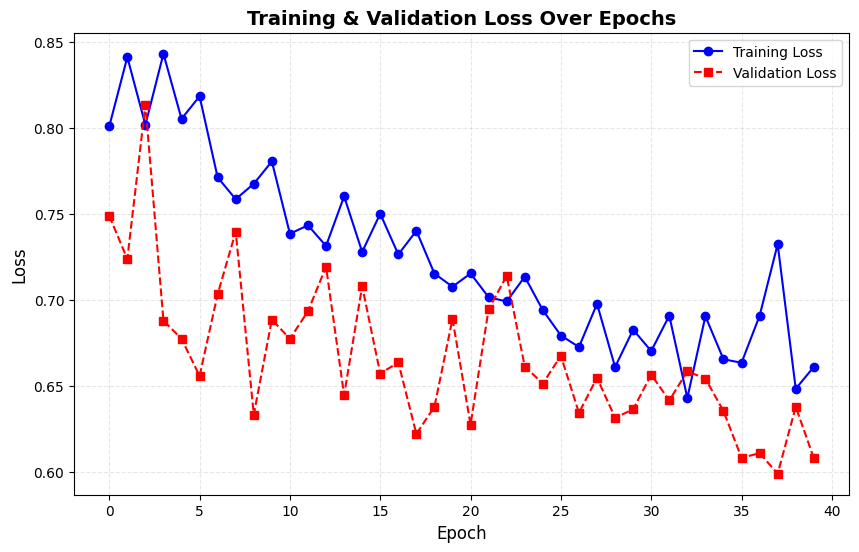

In [38]:

plt.figure(figsize=(10, 6)) 
plt.plot(epoch_losses, label="Training Loss", marker='o', linestyle='-', color='blue') 
plt.plot(val_losses, label="Validation Loss", marker='s', linestyle='--', color='red')  

plt.title("Training & Validation Loss Over Epochs", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)

# plt.xticks(range(len(epoch_losses)))  

plt.legend(loc="upper right", fontsize=10)

plt.grid(alpha=0.3, linestyle='--')
plt.savefig("Task1_1.png")

plt.show()


The best result of regression has been achieved in the 50th epoch with train MSE loss of 0.760755 and test MSE loss of 0.684077.

# 2.Add Unsupervised Finetuning
In this step, you will perform unsupervised fine-tuning on the training dataset. This means the model will leverage only the SMILES strings without any corresponding labels to adapt its understanding of the data distribution. By familiarizing the model with the patterns and structure of the SMILES strings, you can potentially enhance its performance on downstream supervised tasks.

For this fine-tuning, you will use the Masked Language Modeling (MLM) objective, where the model learns to predict randomly masked tokens within the input sequence. Remember to save the fine-tuned model for later use.


In [16]:
smiles = copy.deepcopy(dataset['train'][:]['SMILES'])

In [17]:
tokens = tokenizer(smiles, return_tensors='pt', truncation=True, padding=True)

In [18]:
tokens['labels'] = tokens.input_ids.detach().clone()

In [19]:
mask_token_id = tokenizer.mask_token_id
print(mask_token_id) 

3


This indicates that masking token for MolFormer is 3.

In [20]:
rand = torch.rand(tokens.input_ids.shape)

mask_arr = (rand < 0.15) * (tokens.input_ids != 0) * \
           (tokens.input_ids != 1) * (tokens.input_ids != 2)

In [21]:
selection = []

for i in range(tokens.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i]).nonzero().tolist()
    )

In [22]:
for i in range(tokens.input_ids.shape[0]):
    tokens.input_ids[i, selection[i]] = 3

In [23]:
tokens.input_ids

tensor([[ 0,  4, 13,  ...,  2,  2,  2],
        [ 0,  4,  3,  ...,  2,  2,  2],
        [ 0,  3,  9,  ...,  2,  2,  2],
        ...,
        [ 0,  4,  3,  ...,  2,  2,  2],
        [ 0,  3,  3,  ...,  2,  2,  2],
        [ 0,  4,  3,  ...,  2,  2,  2]])

In [24]:
class SmilesTokenDataSet(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return len(self.encodings.input_ids)
    def __getitem__(self, index):
        return {key: torch.tensor(val[index]) for key, val in self.encodings.items()}

In [25]:
token_dataset = SmilesTokenDataSet(tokens)
token_dataloader = DataLoader(token_dataset, batch_size=BATCH_SIZE, shuffle=True)

The error "MolformerModel.forward() got an unexpected keyword argument 'labels'" suggests that the model you are using (ibm/MoLFormer-XL-both-10pct) does not support a labels argument. In models like BERT, the labels argument is used for Masked Language Modeling (MLM) or sequence classification, but MolFormerModel likely requires a different approach.

In [39]:
raw_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, trust_remote_code=True)
raw_model.to(device)

MolformerForMaskedLM(
  (molformer): MolformerModel(
    (embeddings): MolformerEmbeddings(
      (word_embeddings): Embedding(2362, 768, padding_idx=2)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): MolformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x MolformerLayer(
          (attention): MolformerAttention(
            (self): MolformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (rotary_embeddings): MolformerRotaryEmbedding()
              (feature_map): MolformerFeatureMap(
                (kernel): ReLU()
              )
            )
            (output): MolformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
         

We utilized the same learning rate and number of epochs used to train MolFormer to finetune it. That means we have used a learning rate of 1.6e-4.

In [27]:
raw_model.train()
optimizer = torch.optim.Adam(raw_model.parameters(), lr= 1.6e-4)

EPOCHS_FineTune = 4

In [28]:
for epoch in range(EPOCHS_FineTune):

    loop = tqdm(token_dataloader, leave=True)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = raw_model(input_ids, attention_mask = attention_mask, labels = labels)

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

torch.save(raw_model, "../weights/finetuned_language_model.pth")

  0%|          | 0/263 [00:00<?, ?it/s]C:\Users\Asus\AppData\Local\Temp\ipykernel_24136\1245425547.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
Epoch 3: 100%|██████████| 263/263 [41:19<00:00,  9.43s/it, loss=0.0119] 


# 3.Fine-Tune for Comparison
After performing unsupervised fine-tuning on the training data, we now fine-tune the model on the regression task with the regression head. By comparing the performance of the model before and after unsupervised fine-tuning, you can evaluate how the unsupervised fine-tuning impacts the model's performance on our target task.


In [40]:
class MoLFormerWithRegressionHeadMLM(nn.Module):
    def __init__(self, language_model):
        super().__init__()

        self.language_model = language_model
        self.layer = nn.Sequential(
            # Layer 1
            nn.Linear(768, 407),
            nn.BatchNorm1d(407),
            nn.ELU(),
            nn.Dropout(0.3819889369374411),
            # Layer 2
            nn.Linear(407,427),
            nn.BatchNorm1d(427),
            nn.ELU(),
            nn.Dropout(0.2777819584361112),
            # Layer 3
            nn.Linear(427,240),
            nn.BatchNorm1d(240),
            nn.ELU(),
            nn.Dropout(0.4619253799146514),
            # Layer 4
            nn.Linear(240, 69),
            nn.BatchNorm1d(69),
            nn.ELU(),
            nn.Dropout(0.4497051723910867),
            nn.Linear(69,1)
        )
    
    def forward(self, token):

        smiles_output = self.language_model(**token, output_hidden_states=True)
        smiles_embedding = smiles_output.hidden_states[-1][:, 0, :].detach().float()
        
        return self.layer(smiles_embedding)

In [43]:
finetuned_language_model = torch.load("../weights/finetuned_language_model.pth", map_location="cpu")

regression_model_finetuned = MoLFormerWithRegressionHeadMLM(finetuned_language_model).to(device)

In [44]:
lr = 0.020104429120603076

optimizer = torch.optim.Adam(regression_model_finetuned.parameters(), lr=lr)

epoch_losses_ft = [] 
val_losses_ft = []  


for epoch in range(EPOCHS):
    regression_model_finetuned.train()
    epoch_loss = 0  
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for smiles, label in progress_bar:

        label = label.to(device).float()

        smiles_token = tokenizer(smiles, padding=True, truncation=True, return_tensors="pt")
        smiles_token = {k: v.to(device) for k, v in smiles_token.items()}

        optimizer.zero_grad()
        output = regression_model_finetuned(smiles_token).squeeze()

        loss = F.mse_loss(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    epoch_losses_ft.append(avg_epoch_loss)
    
    regression_model_finetuned.eval()
    val_loss = 0
    with torch.no_grad():
        for smiles, label in test_dataloader:
            
            label = label.to(device).float()
            
            smiles_token = tokenizer(smiles, padding=True, truncation=True, return_tensors="pt")
            smiles_token = {k: v.to(device) for k, v in smiles_token.items()}

            output = regression_model_finetuned(smiles_token).squeeze()

            loss = F.mse_loss(output, label)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_dataloader)
    val_losses_ft.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_epoch_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")

torch.save(regression_model_finetuned, "../weights/regression_w_finetuning_wo_wdecay.pth")

Epoch 1/40, Train Loss: 1.708445, Validation Loss: 1.079857


Epoch 2/40, Train Loss: 1.131258, Validation Loss: 0.861354


Epoch 3/40, Train Loss: 1.047481, Validation Loss: 0.891590


Epoch 4/40, Train Loss: 1.003899, Validation Loss: 0.926022


Epoch 5/40, Train Loss: 0.957442, Validation Loss: 0.738305


Epoch 6/40, Train Loss: 0.954985, Validation Loss: 0.739174


Epoch 7/40, Train Loss: 0.957961, Validation Loss: 0.844730


Epoch 8/40, Train Loss: 0.920739, Validation Loss: 0.854233


Epoch 9/40, Train Loss: 0.913310, Validation Loss: 0.796704


Epoch 10/40, Train Loss: 0.879722, Validation Loss: 0.722789


Epoch 11/40, Train Loss: 0.905199, Validation Loss: 0.711029


Epoch 12/40, Train Loss: 0.887195, Validation Loss: 0.728341


Epoch 13/40, Train Loss: 0.881871, Validation Loss: 0.724460


Epoch 14/40, Train Loss: 0.895542, Validation Loss: 0.706985


Epoch 15/40, Train Loss: 0.869495, Validation Loss: 0.677601


Epoch 16/40, Train Loss: 0.852727, Validation Loss: 0.684274


Epoch 17/40, Train Loss: 0.866852, Validation Loss: 0.642509


Epoch 18/40, Train Loss: 0.867989, Validation Loss: 0.689040


Epoch 19/40, Train Loss: 0.866623, Validation Loss: 0.684175


Epoch 20/40, Train Loss: 0.836020, Validation Loss: 0.660253


Epoch 21/40, Train Loss: 0.855013, Validation Loss: 0.689977


Epoch 22/40, Train Loss: 0.831887, Validation Loss: 0.616985


Epoch 23/40, Train Loss: 0.823669, Validation Loss: 0.736302


Epoch 24/40, Train Loss: 0.860871, Validation Loss: 0.626678


Epoch 25/40, Train Loss: 0.804347, Validation Loss: 0.646310


Epoch 26/40, Train Loss: 0.796886, Validation Loss: 0.622311


Epoch 27/40, Train Loss: 0.836828, Validation Loss: 0.614363


Epoch 28/40, Train Loss: 0.778991, Validation Loss: 0.659032


Epoch 29/40, Train Loss: 0.773135, Validation Loss: 0.615061


Epoch 30/40, Train Loss: 0.810621, Validation Loss: 0.640673


Epoch 31/40, Train Loss: 0.785719, Validation Loss: 0.638574


Epoch 32/40, Train Loss: 0.778674, Validation Loss: 0.689692


Epoch 33/40, Train Loss: 0.759741, Validation Loss: 0.638745


Epoch 34/40, Train Loss: 0.783755, Validation Loss: 0.602735


Epoch 35/40, Train Loss: 0.783782, Validation Loss: 0.617555


Epoch 36/40, Train Loss: 0.770028, Validation Loss: 0.594216


Epoch 37/40, Train Loss: 0.763027, Validation Loss: 0.654334


Epoch 38/40, Train Loss: 0.745391, Validation Loss: 0.682907


Epoch 39/40, Train Loss: 0.740881, Validation Loss: 0.705253


Epoch 40/40, Train Loss: 0.780245, Validation Loss: 0.623258


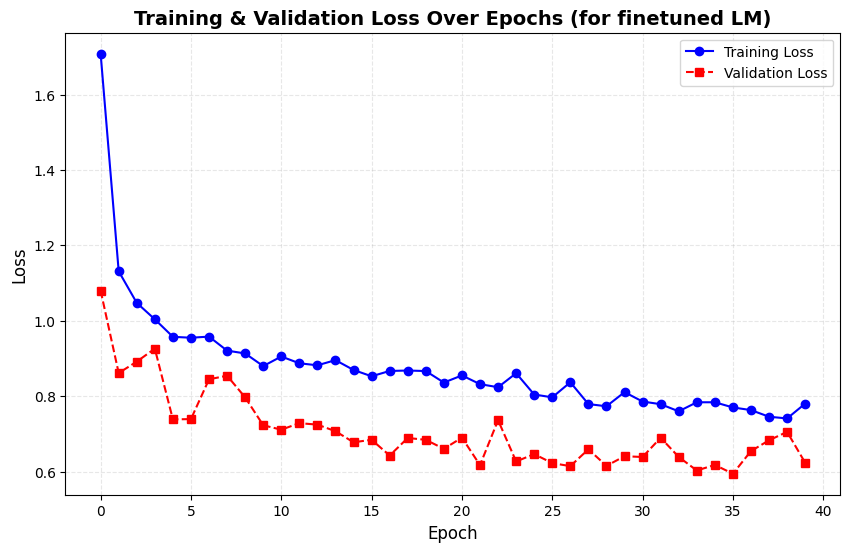

In [45]:

plt.figure(figsize=(10, 6)) 
plt.plot(epoch_losses_ft, label="Training Loss", marker='o', linestyle='-', color='blue') 
plt.plot(val_losses_ft, label="Validation Loss", marker='s', linestyle='--', color='red')  

plt.title("Training & Validation Loss Over Epochs (for finetuned LM)", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)

# plt.xticks(range(len(epoch_losses)))  

plt.legend(loc="upper right", fontsize=10)

plt.grid(alpha=0.3, linestyle='--')
plt.savefig('Task1_2.png')

plt.show()